In [30]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp
from scipy.optimize import root
from scipy.integrate import solve_ivp

In [31]:
class Control_Solver_Plotter:
    def __init__(self):
        self.t = None
        self.x = None
        self.u = None
        self.ode = None
        self.u_func = None
        self.bc = None

    def define_evolution(self,ode,bc):
        self.ode = ode
        self.bc = bc
        return self

    def define_control_function(self,u_func):
        self.u_func = u_func
        return self

    def solve_problem(self, t0, tf=None, n_points=100, x_guess=None):
        param = False
        if tf is None:
            tf = 1
            param = True
        
        self.t = np.linspace(t0, tf, n_points + 1)
        
        # Initialize x_guess if not provided
        if x_guess is None:
            x_guess = np.ones((2,n_points + 1))
        
        # Solve the boundary value problem
        if param:
            param_guess = np.array([1])  # Example parameter guess
            sol = solve_bvp(self.ode, self.bc, self.t, x_guess, param_guess)
        else:
            sol = solve_bvp(self.ode, self.bc, self.t, x_guess)
        
        # Assign solution to class attributes
        self.t = sol.x
        self.x = sol.y
        self.u = self.u_func(sol.y)
        
        return self

    def plot_solution(self,subplot = None,labels =["Pollution"]):
        if subplot is not None:
            if type(subplot) is int:
                plt.subplot(subplot)
            else:
                plt.subplot(*subplot)
        for i,label in enumerate(labels):
            plt.plot(self.t,self.x[i],'k',label = label)
        plt.plot(self.t,self.u,'g',label = "Tax")

        plt.legend()

    def plot_solution_simplest(self,color, subplot = None, ax0=None, ax1=None, labels = None):
        
        
        ax0.plot(self.t,self.x[0],color,label = f'$\\alpha$ = {labels[0]}, $\\beta$={labels[1]}')
        ax1.plot(self.t,self.u,color,label = f'$\\alpha$ = {labels[0]}, $\\beta$={labels[1]}')
        ax0.set_title('Pollution: $x(t)$')
        ax0.set_xlabel("$t$")
        ax0.set_xlim([0,5])
        ax0.legend()
        ax1.set_title(r'Tax: $\tilde{u}(t)$')
        ax1.set_xlabel("$t$")
        ax1.set_xlim([0,5])
        ax1.legend()


# Simplest Problem

In [32]:
def PlotSimplestProblem(alpha, beta, n0, nf, t0, tf, color=None, ax0=None, ax1=None):
    a, b = 2, 1

    def u_func(x):
        def implicitFormula(u):
            return -b/2*x[1] - 2*alpha*u + 1/500*(u / ((a/b)**2 - u**2))
        return root(implicitFormula, x0=np.ones_like(x[1])*0.5).x

    def ode(t,x):
        return np.array([
            .5*(a-b*u_func(x)) - beta*x[0],
            2*x[0] + beta*x[1]
            ])
    def bc(ya,yb):
        return np.array([ya[0]-n0, yb[1]])

    plotter = Control_Solver_Plotter().define_control_function(u_func).define_evolution(ode,bc)
    plotter.solve_problem(t0,tf)
    plotter.plot_solution_simplest(ax0=ax0, ax1=ax1, labels = [alpha, beta], color=color)

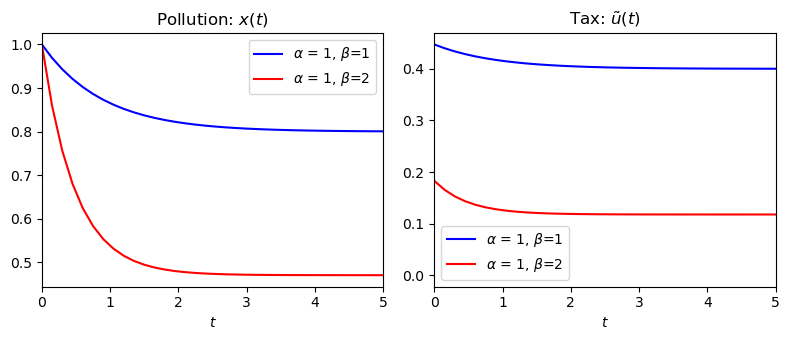

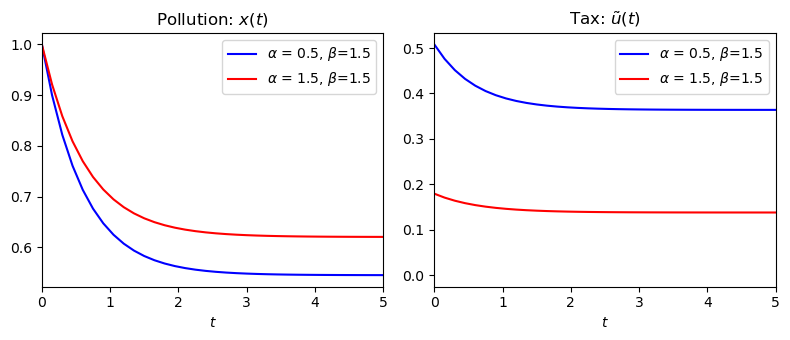

In [33]:
fig, axs = plt.subplots(1,2,figsize=(8,3.5))

colors = ['Blue', 'Red', 'Green', 'Orange', 'Magenta', 'Yellow', 'Black', 'White', 'Gray', 'Cyan']

i = 0
alpha_list = [1] #[1,10]

# Beta values should not be less than .19
# It is realistic to think pollution would not naturally dissipate in the environment
beta_list = [1,2] #[5,10]
for alph in alpha_list:
    for beta in beta_list:
        PlotSimplestProblem(alpha=alph, beta=beta, n0=1, nf=0.5, t0=0, tf=15, ax0=axs.ravel()[i%2], ax1=axs.ravel()[(i+1)%2], color=colors[int(i/2)])
        i += 2
        

# plt.suptitle("Simplest Problem - Variation in $\\beta$")
plt.tight_layout()
plt.savefig('SimplestProblem1.png', dpi = 200)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(8,3.5))
i = 0
alpha_list = [.5, 1.5] #[1,10]

# Beta values should not be less than .19 for a low value of alpha
# It is realistic to think pollution would not naturally dissipate in the environment
beta_list = [1.5] #[5,10]
for alph in alpha_list:
    for beta in beta_list:
        PlotSimplestProblem(alpha=alph, beta=beta, n0=1, nf=0.5, t0=0, tf=15, ax0=axs.ravel()[i%2], ax1=axs.ravel()[(i+1)%2], color=colors[int(i/2)])
        i += 2
        

# plt.suptitle("Simplest Problem - Variation in $\\alpha$")
plt.tight_layout()
plt.savefig('SimplestProblem2.png', dpi = 200)
plt.show()

# Sample Plot for 2 Production Processes

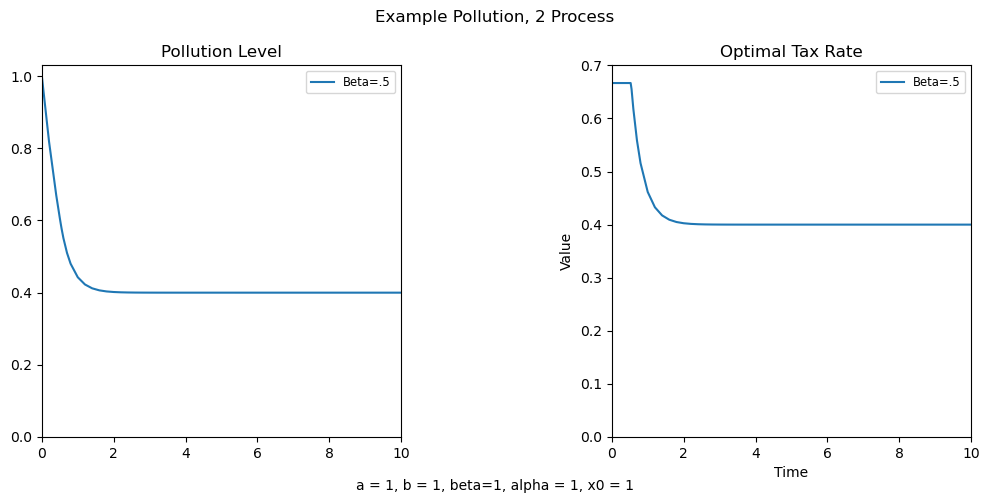

In [34]:
alpha = 10
beta = 1
x0 = 1
t0 = 0
tf = 20


def u_func2(x):
    
    def derivative1(u):
        to_return = np.zeros_like(u)
        for i in range(len(u)):
            if 1 + u[i]/2 <= 4/3:
                to_return[i] = 1 + u[i] / 2
        return to_return
    
    def derivative2(u):
        to_return = np.zeros_like(u)
        for i in range(len(u)):
            if 1 - 3*u[i]/2 >= 0:
                to_return[i] = -3/2
        return to_return
    
    def implicitFormula(u):
        return x[1] * derivative2(u) - alpha * (derivative1(u))

    return np.maximum(np.minimum(root(implicitFormula, x0=np.ones_like(x[1])*.5).x, 2/3), 0)

def ode2(t,x):
    return np.array([
        np.maximum(np.zeros_like(u_func2(x)), 1 - 1.5*u_func2(x)) - beta*x[0],
        2*alpha*x[0] + beta*x[1]
        ])
def bc2(ya,yb):
    return np.array([ya[0]-x0, yb[1]]) #Starting Pollution is n0, ending pollution is free

plotter = Control_Solver_Plotter().define_control_function(u_func2).define_evolution(ode2,bc2)
plotter.solve_problem(t0,tf)
#plotter.plot_solution()
#plt.show()

T1 = plotter.t
X1 = plotter.x[0]
U1 = plotter.u


#Make a plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(T1, X1, label='Beta=.5')
plt.title('Pollution Level')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, 10))

plt.subplot(1, 2, 2)
plt.plot(T1, U1, label='Beta=.5')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Optimal Tax Rate')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, 10))


#Caption
caption = "a = 1, b = 1, beta=1, alpha = 1, x0 = 1"
plt.text(0.5, 0.02, caption, ha='center', fontsize=10, transform=plt.gcf().transFigure)


# Show the plot
plt.suptitle("Example Pollution, 2 Process")
plt.savefig('V4_2_Process_Example.png', dpi=200)
plt.tight_layout()
plt.show()


# Streamlined Function for 2 Goods Case


In [35]:
def two_sol(a, b, alpha, beta, x0, t0, tf):
    #Arrays of Values
    u_vals = []
    x_vals = []
    
    #Two Process Solution
    def u_func2(x):

        def derivative1(u):
            to_return = np.zeros_like(u)
            for i in range(len(u)):
                if 1 + u[i]/2 <= 4/3:
                    to_return[i] = 1 + u[i] / 2
            return to_return

        def derivative2(u):
            to_return = np.zeros_like(u)
            for i in range(len(u)):
                if 1 - 3*u[i]/2 >= 0:
                    to_return[i] = -3/2
            return to_return

        def implicitFormula(u):
            return x[1] * derivative2(u) - alpha * (derivative1(u))

        return np.maximum(np.minimum(root(implicitFormula, x0=np.ones_like(x[1])*.5).x, 2/3), 0)

    def ode2(t,x):
        return np.array([
            np.maximum(np.zeros_like(u_func2(x)), 1 - 1.5*u_func2(x)) - beta*x[0],
            2*alpha*x[0] + beta*x[1]
            ])
    def bc2(ya,yb):
        return np.array([ya[0]-x0, yb[1]])


    #Solve the problem
    plotter = Control_Solver_Plotter().define_control_function(u_func2).define_evolution(ode2,bc2)
    plotter.solve_problem(t0,tf)

    t_vals = plotter.t
    x_vals = plotter.x[0]
    u_vals = plotter.u
    
    return x_vals, u_vals


# Plot for Different Values of Beta, 2 Process

In [36]:
#Parameters
a = 2
b = 1
alpha = 1
#beta = 1
x0 = 1
t0 = 0
tf = 40

beta_vals = [i / 4 for i in range(1, 7)]

x_val_list = []
u_val_list = []

for beta_ in beta_vals:
    x_vals, u_vals = two_sol(a, b, alpha, beta_, x0, t0, tf)
    x_val_list.append(x_vals)
    u_val_list.append(u_vals)

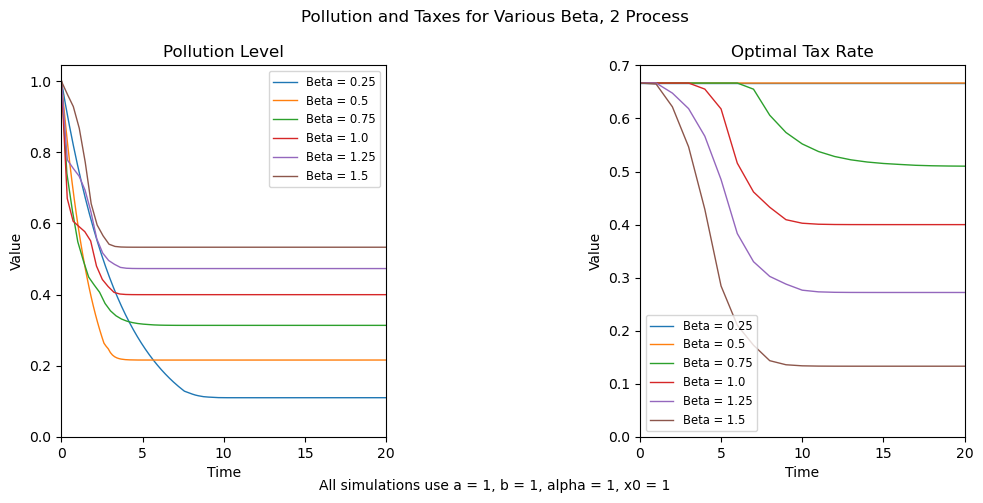

In [37]:
#Make the plot

plt.figure(figsize=(10, 5))

for i in range(len(beta_vals)):
    label = "Beta = " + str(beta_vals[i])
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(0, tf, len(x_val_list[i])), x_val_list[i], label=label, lw=1)
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(u_val_list[i])), u_val_list[i], label=label, lw=1)
    
    
# Add labels and legend
plt.subplot(1, 2, 1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Pollution Level')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, 20))

plt.subplot(1, 2, 2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Optimal Tax Rate')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, 20))

#Caption
caption = "All simulations use a = 1, b = 1, alpha = 1, x0 = 1"
plt.text(0.5, 0.02, caption, ha='center', fontsize=10, transform=plt.gcf().transFigure)


# Show the plot
plt.suptitle("Pollution and Taxes for Various Beta, 2 Process")
plt.savefig('V4_2_Process_Beta.png', dpi=200)
plt.tight_layout()
plt.show()


# Plot for Different Values of Alpha, 2 Process

In [38]:
#Parameters
a = 2
b = 1
#alpha = 1
beta = 1
x0 = 1
t0 = 0
tf = 40

alpha_vals = [2**(i) for i in range(-2, 5)]

x_val_list_alpha = []
u_val_list_alpha = []

for alpha_ in alpha_vals:
    x_vals, u_vals = two_sol(a, b, alpha_, beta, x0, t0, tf)
    x_val_list_alpha.append(x_vals)
    u_val_list_alpha.append(u_vals)


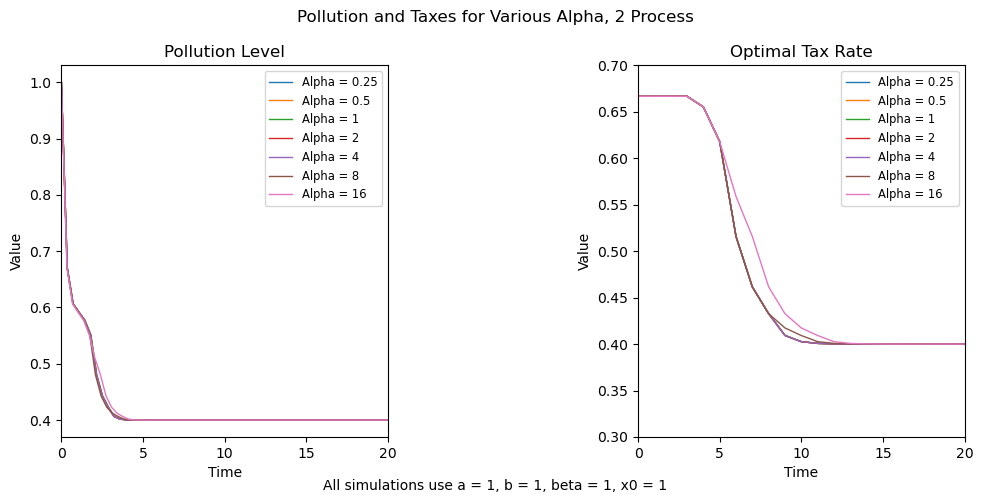

In [39]:
#Make the plot

plt.figure(figsize=(10, 5))

for i in range(len(alpha_vals)):
    label = "Alpha = " + str(alpha_vals[i])
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(0, tf, len(x_val_list_alpha[i])), x_val_list_alpha[i], label=label, lw=1)
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(u_val_list_alpha[i])), u_val_list_alpha[i], label=label, lw=1)
    
    
# Add labels and legend
plt.subplot(1, 2, 1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Pollution Level')
plt.legend(fontsize='small')
plt.xlim((0, 20))

plt.subplot(1, 2, 2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Optimal Tax Rate')
plt.legend(fontsize='small')
plt.xlim((0, 20))
plt.ylim((0.3, 0.7))

#Caption
caption = "All simulations use a = 1, b = 1, beta = 1, x0 = 1"
plt.text(0.5, 0.02, caption, ha='center', fontsize=10, transform=plt.gcf().transFigure)


# Show the plot
plt.suptitle("Pollution and Taxes for Various Alpha, 2 Process")
plt.tight_layout()
plt.savefig('V4_2_Process_Alpha.png', dpi=200)
plt.show()


# Plot for Different Starting Values x0, 2 Process


In [40]:
#Parameters
a = 2
b = 1
alpha = 1
beta = 1
#x0 = 1
t0 = 0
tf = 40

x0_vals = [0, 0.25, 0.5, 1, 2, 4, 8]

x_val_list_x0 = []
u_val_list_x0 = []

for x0_ in x0_vals:
    x_vals, u_vals = two_sol(a, b, alpha, beta, x0_, t0, tf)
    x_val_list_x0.append(x_vals)
    u_val_list_x0.append(u_vals)

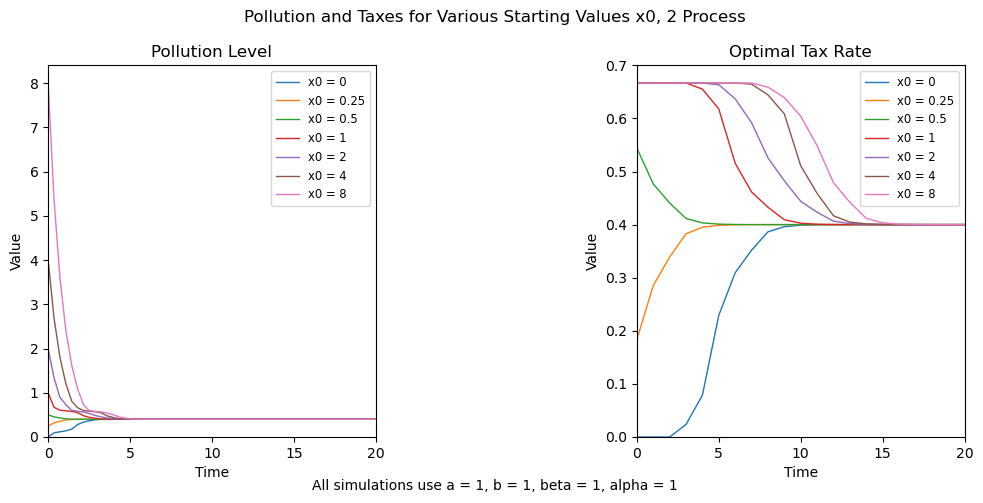

In [41]:
#Make the plot

plt.figure(figsize=(10, 5))

for i in range(len(x0_vals)):
    label = "x0 = " + str(x0_vals[i])
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(0, tf, len(x_val_list_x0[i])), x_val_list_x0[i], label=label, lw=1)
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(u_val_list_x0[i])), u_val_list_x0[i], label=label, lw=1)
    
    
# Add labels and legend
plt.subplot(1, 2, 1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Pollution Level')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, 20))

plt.subplot(1, 2, 2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Optimal Tax Rate')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, 20))

#Caption
caption = "All simulations use a = 1, b = 1, beta = 1, alpha = 1"
plt.text(0.5, 0.02, caption, ha='center', fontsize=10, transform=plt.gcf().transFigure)

# Show the plot
plt.suptitle("Pollution and Taxes for Various Starting Values x0, 2 Process")
plt.tight_layout()
plt.savefig('V4_2_Process_x0.png', dpi=200)
plt.show()


# Solver for Discrete Case

In [42]:
def x_1_ode(t, x, beta, u):
    return -beta * x + (1 - u/2)

t_span = (0, 1)
t_eval = np.linspace(0,1,101)

def iterated_sol(a, b, alpha, beta, x0, t0, tf):
    #Arrays of Values
    u_vals = []
    x_vals = []
    
    #Standard Problem we are solving
    def u_func(x):
        def implicitFormula(u):
            return -b/2 * x[1] - 2*alpha*u - 2*u / (a**2 / b**2 - u**2 ) / 1000
        return root(implicitFormula, x0=np.ones_like(x[1])*0.1).x
    def ode(t,x):
        return np.array([
            .5*(b-a*u_func(x)) - beta*x[0],
            2*x[0] + beta*x[1]
            ])
    def bc(ya,yb):
        return np.array([ya[0]-x0, yb[1]])

    #Iterated Solution
    for t in range(tf+1):
    
        #Solve the problem, get optimal u
        plotter = Control_Solver_Plotter().define_control_function(u_func).define_evolution(ode,bc)
        plotter.solve_problem(t0,tf)
        u = plotter.u[0]

        #Let the system evolve, get new pollution level
        x = solve_ivp(x_1_ode, t_span, [x0], args=(beta, u), t_eval = t_eval).y[0]
        x0 = x[-1]

        x_vals.extend(x)
        u_vals.append(u)

    return x_vals, u_vals


def iterated_plot(x_vals, u_vals, ax, subplot=False):
    # Plot the pollution level over time
    ax.plot(np.linspace(0, 10, len(x_vals)), x_vals, label='Pollution Level', lw=4)

    # Plot the optimal control value over time
    ax.step(np.arange(len(u_vals)), u_vals, where='post', label='Optimal Control', lw=4)



# Example, Discrete

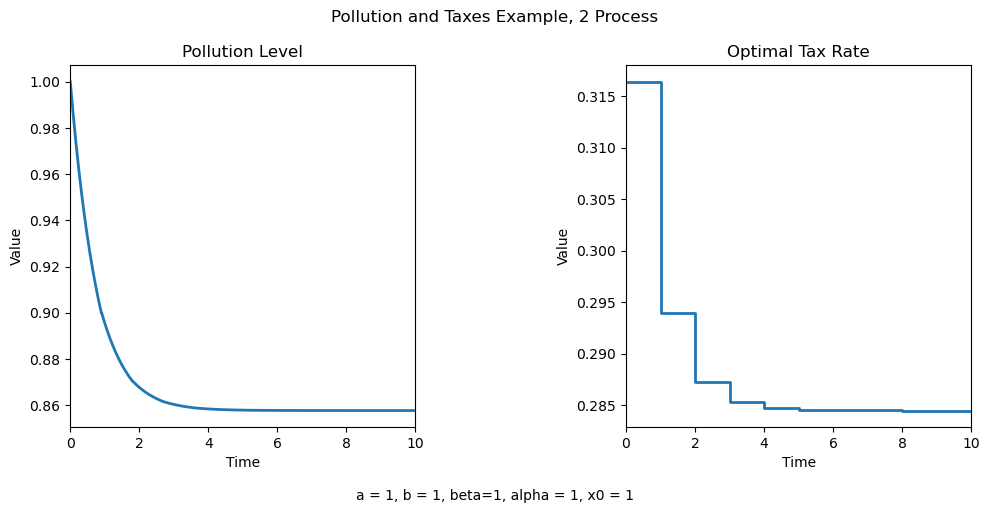

In [43]:
#Parameters
a = 2
b = 1
alpha = 1
beta = 1
x0 = 1
t0 = 0
tf = 10

x_vals, u_vals = iterated_sol(a, b, alpha, beta, x0, t0, tf)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, 10, len(x_vals)), x_vals, lw=2)
plt.subplot(1, 2, 2)
plt.step(np.arange(len(u_vals)), u_vals, where='post', lw=2)

    
# Add labels and legend

plt.subplot(1, 2, 1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Pollution Level')
plt.xlim((0, tf))

plt.subplot(1, 2, 2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Optimal Tax Rate')
plt.xlim((0, tf))


#Caption
caption = "a = 1, b = 1, beta=1, alpha = 1, x0 = 1"
plt.text(0.5, 0, caption, ha='center', fontsize=10, transform=plt.gcf().transFigure)


# Show the plot
plt.suptitle("Pollution and Taxes Example, 2 Process")
plt.savefig('V4_Discrete_Example.png', dpi=200)
plt.tight_layout()
plt.show()



# Plot For Different Values of Beta, Discrete

In [44]:
#Parameters
a = 2
b = 1
alpha = 1
#beta = 1
x0 = 1
t0 = 0
tf = 10

beta_vals = [i / 5 for i in range(1, 11)]

x_val_list = []
u_val_list = []

for beta_ in beta_vals:
    x_vals, u_vals = iterated_sol(a, b, alpha, beta_, x0, t0, tf)
    x_val_list.append(x_vals)
    u_val_list.append(u_vals)

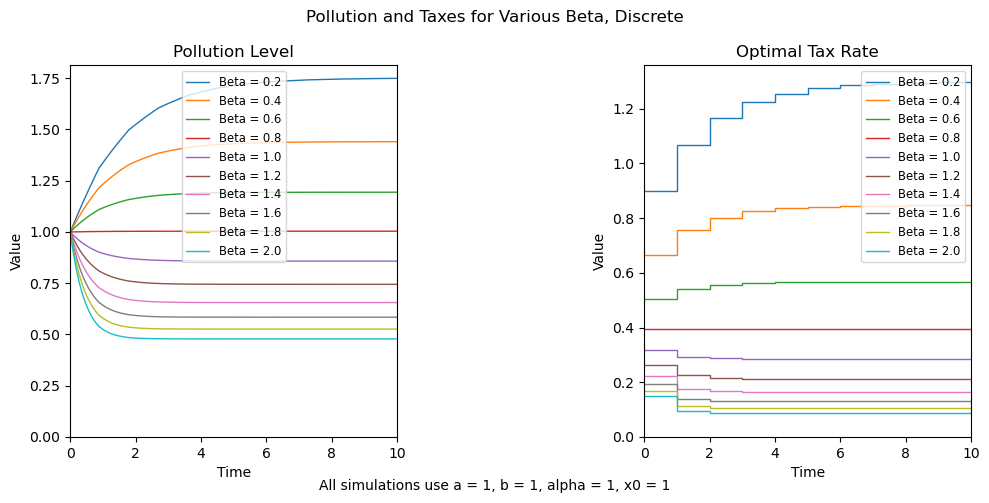

In [45]:
#Make the plot

plt.figure(figsize=(10, 5))

for i in range(len(beta_vals)):
    label = "Beta = " + str(beta_vals[i])
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(0, 10, len(x_val_list[i])), x_val_list[i], label=label, lw=1)
    plt.subplot(1, 2, 2)
    plt.step(np.arange(len(u_val_list[i])), u_val_list[i], where='post', label=label, lw=1)
    
    
# Add labels and legend
plt.subplot(1, 2, 1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Pollution Level')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, tf))

plt.subplot(1, 2, 2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Optimal Tax Rate')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, tf))

#Caption
caption = "All simulations use a = 1, b = 1, alpha = 1, x0 = 1"
plt.text(0.5, 0.02, caption, ha='center', fontsize=10, transform=plt.gcf().transFigure)


# Show the plot
plt.suptitle("Pollution and Taxes for Various Beta, Discrete")
plt.tight_layout()
plt.savefig('V4_Discrete_Beta.png', dpi=200)
plt.show()


# Plot for Different Values of Alpha, Discrete

In [46]:
#Parameters
a = 2
b = 1
#alpha = 1
beta = 1
x0 = 1
t0 = 0
tf = 10

alpha_vals = [2**(i) for i in range(-2, 5)]

x_val_list_alpha = []
u_val_list_alpha = []

for alpha_ in alpha_vals:
    x_vals, u_vals = iterated_sol(a, b, alpha_, beta, x0, t0, tf)
    x_val_list_alpha.append(x_vals)
    u_val_list_alpha.append(u_vals)


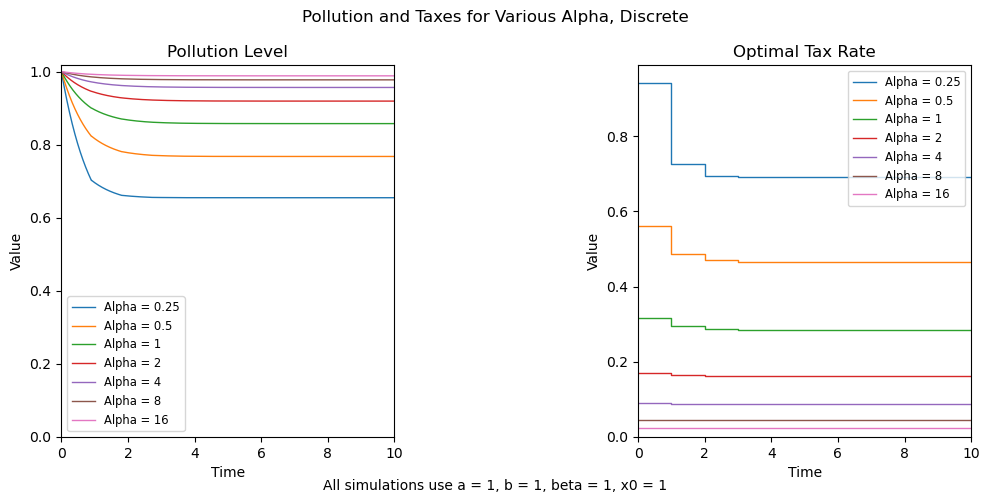

In [47]:
#Make the plot

plt.figure(figsize=(10, 5))

for i in range(len(alpha_vals)):
    label = "Alpha = " + str(alpha_vals[i])
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(0, 10, len(x_val_list_alpha[i])), x_val_list_alpha[i], label=label, lw=1)
    plt.subplot(1, 2, 2)
    plt.step(np.arange(len(u_val_list_alpha[i])), u_val_list_alpha[i], where='post', label=label, lw=1)
    
    
# Add labels and legend
plt.subplot(1, 2, 1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Pollution Level')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, tf))

plt.subplot(1, 2, 2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Optimal Tax Rate')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, tf))

#Caption
caption = "All simulations use a = 1, b = 1, beta = 1, x0 = 1"
plt.text(0.5, 0.02, caption, ha='center', fontsize=10, transform=plt.gcf().transFigure)


# Show the plot
plt.suptitle("Pollution and Taxes for Various Alpha, Discrete")
plt.tight_layout()
plt.savefig('V4_Discrete_Alpha.png', dpi=200)
plt.show()


# Plot for Different Values of x0, Discrete

In [48]:
#Parameters
a = 2
b = 1
alpha = 1
beta = 1
#x0 = 1
t0 = 0
tf = 10

x0_vals = [0, 0.25, 0.5, 1, 2, 4, 8]

x_val_list_x0 = []
u_val_list_x0 = []

for x0_ in x0_vals:
    x_vals, u_vals = iterated_sol(a, b, alpha, beta, x0_, t0, tf)
    x_val_list_x0.append(x_vals)
    u_val_list_x0.append(u_vals)

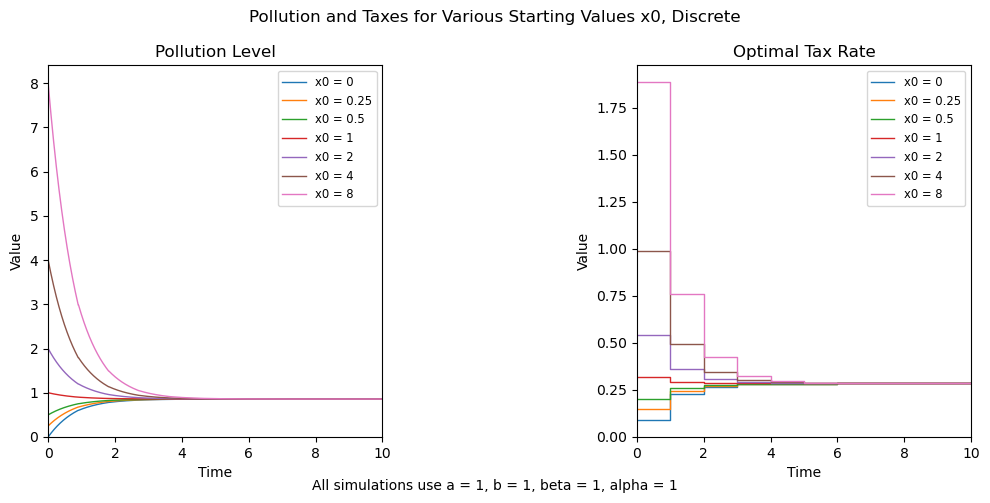

In [49]:
#Make the plot

plt.figure(figsize=(10, 5))

for i in range(len(x0_vals)):
    label = "x0 = " + str(x0_vals[i])
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(0, 10, len(x_val_list_x0[i])), x_val_list_x0[i], label=label, lw=1)
    plt.subplot(1, 2, 2)
    plt.step(np.arange(len(u_val_list_x0[i])), u_val_list_x0[i], where='post', label=label, lw=1)
    
    
# Add labels and legend
plt.subplot(1, 2, 1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Pollution Level')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, tf))

plt.subplot(1, 2, 2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Optimal Tax Rate')
plt.legend(fontsize='small')
plt.ylim((0, None))
plt.xlim((0, tf))

#Caption
caption = "All simulations use a = 1, b = 1, beta = 1, alpha = 1"
plt.text(0.5, 0.02, caption, ha='center', fontsize=10, transform=plt.gcf().transFigure)

# Show the plot
plt.suptitle("Pollution and Taxes for Various Starting Values x0, Discrete")
plt.tight_layout()
plt.savefig('V4_Discrete_x0.png', dpi=200)
plt.show()
